In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### Load RF model

In [18]:
RF_score = 'gini'
yr_start = 2019
yr_end = 2021
mask = 'SIMPLE_MASK'
stand_str = 'STANDARDIZED'
RI_thresh = 30
weights = 'default'
N_samples_RF = 10
scoring = 'f1_weighted'
RF_dir = '~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/'
RF_ext = '_{RF_score}_SHIPS_VALID_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{scoring}.csv'.format(RF_score='Random Forest',yr_start=yr_start,yr_end=yr_end,mask=mask,
            stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,scoring=scoring)


In [19]:
RF_dir+'PREDICTED_Y_vals'+RF_ext

'~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/PREDICTED_Y_vals_Random Forest_SHIPS_VALID_RI_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30weights_default_wts_f1_weighted.csv'

##### Load LR Model

In [34]:
LR_models = ['lbfgs','saga']
valid_yr_start = 2019
valid_yr_end = 2021
#N_samples_LR = 15
LR_dir = '~/SHIPS/SHIPS_clean/Model_Results/VALIDATION/'
LR_ext1 = '_{model}_SHIPS_VALID_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{scoring}.csv'.format(model=LR_models[0],yr_start=valid_yr_start,
                                            yr_end=valid_yr_end,mask=mask,
                                  stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,scoring=scoring)
LR_ext2 = '_{model}_SHIPS_VALID_RI_vs_no_RI_{yr_start}-{yr_end}_{mask}_{stand_str}_RI_thresh_{RI_thresh}weights_'\
'{weights}_wts_{scoring}.csv'.format(model=LR_models[1],yr_start=valid_yr_start,yr_end=valid_yr_end,mask=mask,
                                  stand_str=stand_str,RI_thresh=RI_thresh,weights=weights,scoring=scoring)

In [35]:
y_pred_LR1 = pd.read_csv(LR_dir+'PREDICTED_Y_vals'+LR_ext1)
y_pred_LR1 = y_pred_LR1.rename(columns={'Y test':'Y true'})
y_pred_LR2 = pd.read_csv(LR_dir+'PREDICTED_Y_vals'+LR_ext2)
y_pred_LR2 = y_pred_LR2.rename(columns={'Y test':'Y true'})
y_pred_RF = pd.read_csv(RF_dir+'PREDICTED_Y_vals'+RF_ext)
y_pred_RF = y_pred_RF.rename(columns={'Y test':'Y true'})
y_pred_res = pd.concat([y_pred_RF,y_pred_LR1,y_pred_LR2])

In [36]:
#y_pred_res = y_pred_res.rename(columns={'Y test':'Y true'})
y_pred_res['Y pred probab (class: 1)'] = y_pred_res['Y pred probab (class: 1)']*100

In [37]:
y_pred_res['RI prob'] = (y_pred_res['Y pred probab (class: 1)']).round(-1)

In [38]:
y_pred_res['RI prob'] = y_pred_res['RI prob'].mask(y_pred_res['RI prob'] <= 5, 5)

In [39]:
y_pred_res = y_pred_res.drop(columns={'BASIN','Unnamed: 0'})
# y_pred_res = y_pred_res[y_pred_res['Predicted Basin']!='ALL']

In [40]:
pct_range = y_pred_res['RI prob'].unique().tolist()
reliability = pd.DataFrame()
#for ipct in pct_range:
ipct = 100
y_sel = y_pred_res.set_index(['RI prob']).xs(ipct)
total = y_sel.groupby(['Predicted Basin','Model']).count()
#RI = y_sel[y_sel['Y true']==1].groupby(['Predicted Basin','Model']).count()
#i_df = pd.DataFrame(index=total.index,columns={'Observed Pct','Predicted Pct'})

In [59]:
hi_pr = y_pred_res.set_index(['RI prob']).loc[([90,100])]


In [64]:
pct_range = y_pred_res['RI prob'].unique().tolist()
reliability = pd.DataFrame()
for ipct in pct_range:
    # ipct = 10
    y_sel = y_pred_res.set_index(['RI prob']).xs(ipct)
    total = y_sel.groupby(['Predicted Basin','Model']).count()
    RI = y_sel[y_sel['Y true']==1].groupby(['Predicted Basin','Model']).count()
    i_df = pd.DataFrame(index=total.index,columns={'Observed Pct','Predicted Pct'})
    if len(RI) == 0:
        pct = 0
        i_df['Observed Pct'] = 0
        i_df['Observed No. RI'] = 0
    else:
        pct = 100*(RI/total)
        i_df['Observed Pct'] = pct['CASE']
        i_df['Observed No. RI'] = RI['CASE']
    i_df['Predicted Pct'] = ipct
    i_df['Observed No Total'] = total['CASE']
    reliability = reliability.append(i_df)

In [65]:
reliability = reliability.mask(reliability.isna(),0)

In [68]:
reliability.reset_index().set_index(['Predicted Pct']).loc[([90,100])]

,Predicted Basin,Model,Observed Pct,Observed No. RI,Observed No Total
Predicted Pct,,,,,
90.0,ALL,lbfgs,38.095238,8.0,21
90.0,ALL,saga,38.095238,8.0,21
90.0,ATLANTIC,lbfgs,33.333333,1.0,3
90.0,ATLANTIC,saga,33.333333,1.0,3
90.0,EAST_PACIFIC,lbfgs,25.000000,1.0,4
90.0,EAST_PACIFIC,saga,25.000000,1.0,4
90.0,SOUTH_PACIFIC,lbfgs,25.000000,2.0,8
90.0,SOUTH_PACIFIC,saga,25.000000,2.0,8
90.0,WEST_PACIFIC,lbfgs,66.666667,4.0,6


In [61]:
reliability#.xs(('ALL','Random Forest')).sort_values(['Predicted Pct'])
palette = {'xkcd:turquoise','xkcd:coral','xkcd:tangerine'}
basin_ALL = reliability.reset_index()['Predicted Basin'].unique().tolist()
#foo = reliability.xs(('ALL'))
#foo2 = foo.xs(~'lbfgs').sort_values(['Predicted Pct'])
#foo = reliability.xs('ALL').reset_index()
#foo = foo[foo['Model']!='lbfgs']
#foo
reliability
# y_pred_res.set_index(['RI prob','Predicted Basin','Model']).xs((10,'ATLANTIC','Random Forest'))

KeyError: 'Predicted Basin'

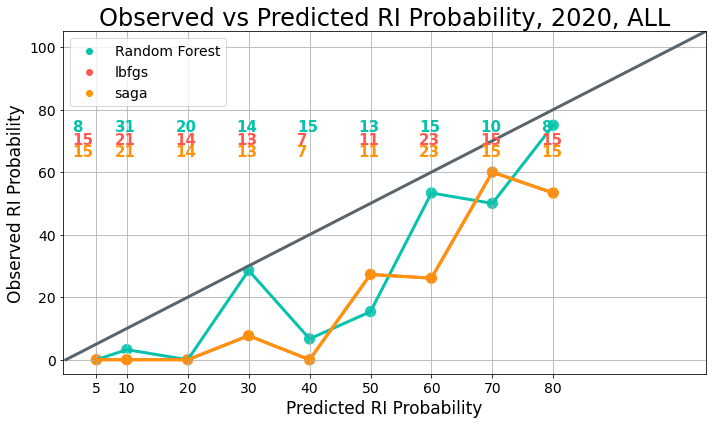

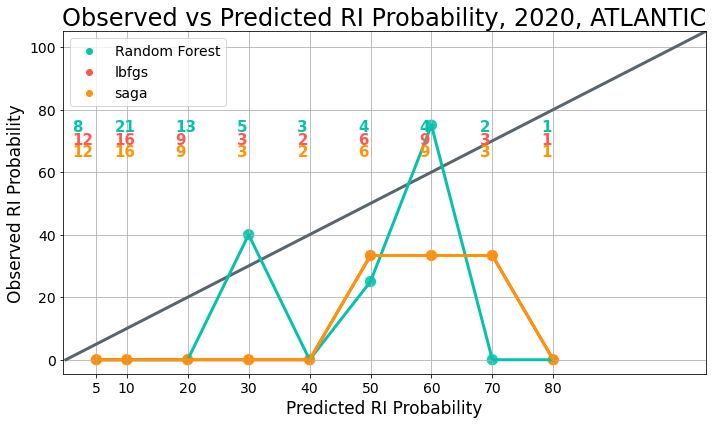

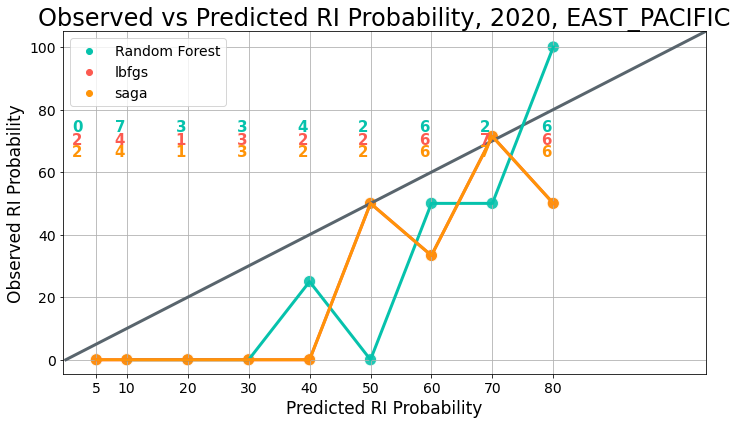

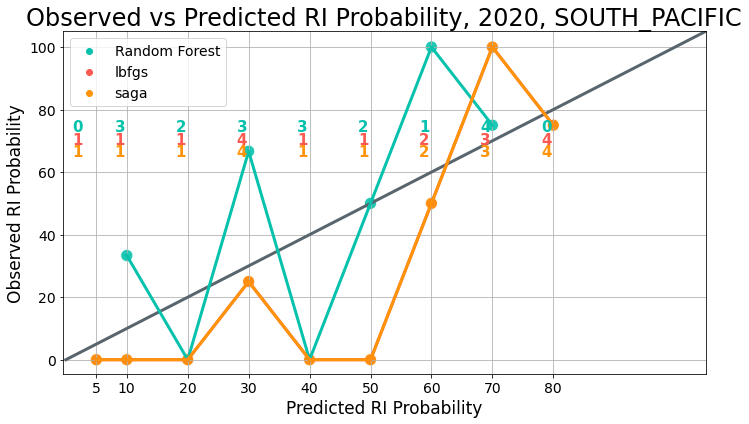

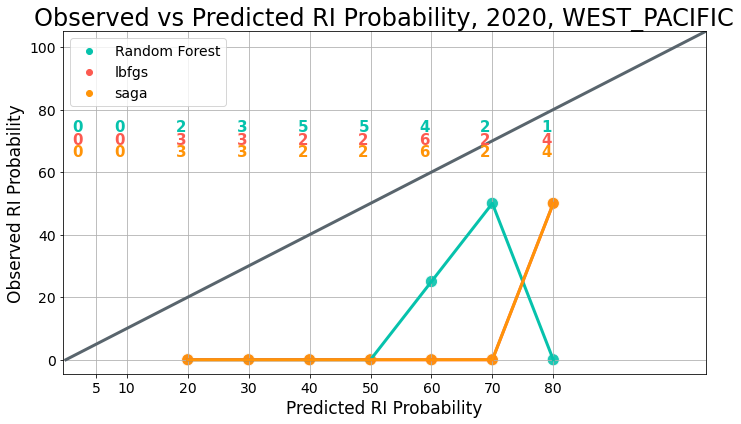

In [15]:
for basin_sel in basin_ALL:
    fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
    #basin_sel = 'ALL'
    ax1.plot([0,105],[0,105],linewidth=3,color='xkcd:slate grey')
    sns.scatterplot(data=reliability.xs(basin_sel),x='Predicted Pct',y='Observed Pct',hue='Model',
                    palette=sns.set_palette(palette),ax=ax1,s=150,alpha=0.9)
    sns.lineplot(data=reliability.xs(basin_sel).reset_index(),x='Predicted Pct',y='Observed Pct',
                hue='Model',palette=sns.set_palette(palette),ax=ax1,linewidth=3,legend=False)
    #sns.scatterplot(data=foo,x='Predicted Pct',y='Observed Pct',hue='Model',
     #              palette=sns.set_palette(palette),ax=ax1,s=150,alpha=0.8)    
    ax1.set_ylim([-4.5,105])
    ax1.set_xlim([-0.5,105])
    ax1.set_xticks(pct_range)
    ax1.tick_params(axis='y',labelsize=14)
    ax1.tick_params(axis='x',labelsize=14)
    ax1.legend(fontsize=14)
    ax1.set_xlabel('Predicted RI Probability',fontsize=17)
    ax1.set_ylabel('Observed RI Probability',fontsize=17)
    plt_nums = reliability.xs(basin_sel).sort_values(['Predicted Pct']).reset_index().set_index(['Predicted Pct'])
    ax1.grid()
    # 
    totals = reliability.xs(basin_sel).reset_index().sort_values('Predicted Pct').set_index(['Model','Predicted Pct'])
    models_list = reliability.reset_index()['Model'].unique().tolist()
    for i in models_list:
        mod_sel = totals.xs(i)
        for i_pct in pct_range:
            if i_pct in mod_sel.index:
                imod = mod_sel.xs(i_pct)['Observed No Total'].astype(int)
            else:
                imod = 0
            if i == 'Random Forest':
                yval = (69+4 if i_pct < 90 else 79 -6)
                i_color = sns.color_palette()[0]
            elif i == 'lbfgs':
                yval = (65+4 if i_pct < 90 else 75 -6)
                i_color = sns.color_palette()[1]
            elif i == 'saga':
                yval = (61+4 if i_pct < 90 else 71 -6)
                i_color = sns.color_palette()[2]
            #
            ax1.text((i_pct-4 if i_pct == 5 else i_pct -2),yval,imod,color=i_color,fontsize=15,weight='semibold')
    ax1.set_title('Observed vs Predicted RI Probability, 2020, {basin_sel}'.format(basin_sel=basin_sel),fontsize=24)
    fig1.tight_layout()
    fig1.savefig('Figures/reliability_ML_models_2020_{basin_sel}.png'.format(basin_sel=basin_sel),
                format='png',bbox_inches='tight',dpi=300)
    fig1.savefig('Figures/reliability_ML_models_2020_{basin_sel}.pdf'.format(basin_sel=basin_sel),
                format='pdf',bbox_inches='tight')

In [16]:
plt_nums = reliability.xs(('ALL')).sort_values(['Predicted Pct']).reset_index().set_index(['Predicted Pct','Model'])
plt_nums.index.get_level_values(0)

Float64Index([ 5.0,  5.0,  5.0, 10.0, 10.0, 10.0, 20.0, 20.0, 20.0, 30.0, 30.0,
              30.0, 40.0, 40.0, 40.0, 50.0, 50.0, 50.0, 60.0, 60.0, 60.0, 70.0,
              70.0, 70.0, 80.0, 80.0, 80.0],
             dtype='float64', name='Predicted Pct')

In [17]:
models_list = plt_nums.reset_index()['Model'].unique()
models_list

array(['saga', 'lbfgs', 'Random Forest'], dtype=object)